# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/noisy_port-80_percentage-0.0.pcap/result-lstm-tcp80-hl2-seq4-do0.2-oov2500-Tuesday-WorkingHours_testing_80.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')

In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.5-49199-104.88.60.48-80-tcp,0.286517,1,1,1,204895.994253,1,1,1
1,192.168.10.5-49198-23.15.4.19-80-tcp,0.237838,1,1,1,139854.171271,0,0,0
2,192.168.10.5-49200-23.52.146.130-80-tcp,0.377778,1,1,1,224314.961832,1,1,1
3,192.168.10.5-49197-23.217.41.219-80-tcp,0.280822,1,1,1,109870.935484,0,0,0
4,192.168.10.5-49201-23.202.233.152-80-tcp,0.200893,1,1,1,104219.504545,0,0,0


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.5-88-49182-6,192.168.10.5,49182,192.168.10.3,88,6,4/7/2017 8:54,640,7,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.5-88-49183-6,192.168.10.5,49183,192.168.10.3,88,6,4/7/2017 8:54,900,9,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.5-88-49184-6,192.168.10.5,49184,192.168.10.3,88,6,4/7/2017 8:54,1205,7,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.5-88-49185-6,192.168.10.5,49185,192.168.10.3,88,6,4/7/2017 8:54,511,7,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.5-88-49186-6,192.168.10.5,49186,192.168.10.3,88,6,4/7/2017 8:54,773,9,4,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## Exploratory Data Analysis

In [5]:
df_truth[[' Label']].value_counts()

 Label     
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name: count, dtype: int64

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
1        24026
0         3481
Name: count, dtype: int64

In [7]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           23572
0            3935
Name: count, dtype: int64

In [8]:
df_truth.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [9]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 80
df_truth = df_truth[(df_truth['Source_Port'] == 80) | (df_truth['Destination_Port'] == 80)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62467 entries, 15 to 445895
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      62467 non-null  object 
 1   Source_IP                    62467 non-null  object 
 2   Source_Port                  62467 non-null  int64  
 3   Destination_IP               62467 non-null  object 
 4   Destination_Port             62467 non-null  int64  
 5   Protocol                     62467 non-null  int64  
 6   Timestamp                    62467 non-null  object 
 7   Flow_Duration                62467 non-null  int64  
 8   Total_Fwd_Packets            62467 non-null  int64  
 9   Total_Backward_Packets       62467 non-null  int64  
 10  Total_Length_of_Fwd_Packets  62467 non-null  int64  
 11  Total_Length_of_Bwd_Packets  62467 non-null  float64
 12  Fwd_Packet_Length_Max        62467 non-null  int64  
 13  Fwd_Packet_Length_M

In [10]:
df_truth['Label'].head()

15    BENIGN
26    BENIGN
27    BENIGN
29    BENIGN
31    BENIGN
Name: Label, dtype: object

In [11]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_348843/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [12]:
df_pred["id"]

0           192.168.10.5-49199-104.88.60.48-80-tcp
1             192.168.10.5-49198-23.15.4.19-80-tcp
2          192.168.10.5-49200-23.52.146.130-80-tcp
3          192.168.10.5-49197-23.217.41.219-80-tcp
4         192.168.10.5-49201-23.202.233.152-80-tcp
                           ...                    
27502    192.168.10.19-56284-148.251.185.11-80-tcp
27503      192.168.10.9-12883-172.217.9.238-80-tcp
27504      192.168.10.9-12884-172.217.9.238-80-tcp
27505     192.168.10.16-49386-194.244.5.206-80-tcp
27506     192.168.10.19-55962-23.21.240.128-80-tcp
Name: id, Length: 27507, dtype: object

In [13]:
df_truth["id"]

15        192.168.10.5-49201-23.202.233.152-80-tcp
26         192.168.10.5-49213-172.217.6.206-80-tcp
27         192.168.10.5-49211-172.217.6.206-80-tcp
29           192.168.10.5-49208-72.21.91.29-80-tcp
31         192.168.10.5-49206-184.25.102.48-80-tcp
                            ...                   
445846       72.21.91.29-80-192.168.10.5-53639-tcp
445857     192.168.10.16-40494-104.24.21.85-80-tcp
445872     52.84.143.81-80-192.168.10.51-43469-tcp
445884    165.254.94.83-80-192.168.10.16-46190-tcp
445895    54.235.150.88-80-192.168.10.25-59865-tcp
Name: id, Length: 62467, dtype: object

In [14]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [16]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label


In [17]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.5-49199-104.88.60.48-80-tcp,0.286517,1,1,1,204895.994253,1,1,1,0
1,192.168.10.5-49198-23.15.4.19-80-tcp,0.237838,1,1,1,139854.171271,0,0,0,0
2,192.168.10.5-49200-23.52.146.130-80-tcp,0.377778,1,1,1,224314.961832,1,1,1,0
3,192.168.10.5-49197-23.217.41.219-80-tcp,0.280822,1,1,1,109870.935484,0,0,0,0
4,192.168.10.5-49201-23.202.233.152-80-tcp,0.200893,1,1,1,104219.504545,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
51555,192.168.10.9-12883-172.217.9.238-80-tcp,0.222222,1,1,1,152362.931889,0,0,0,0
51556,192.168.10.9-12884-172.217.9.238-80-tcp,0.223256,1,1,1,154032.009390,0,0,0,0
51557,192.168.10.16-49386-194.244.5.206-80-tcp,0.175084,1,1,1,87484.587031,0,0,0,0
51558,192.168.10.16-49386-194.244.5.206-80-tcp,0.175084,1,1,1,87484.587031,0,0,0,0


In [18]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.5-49199-104.88.60.48-80-tcp,0.286517,1,1,1,204895.994253,1,1,1,0
1,192.168.10.5-49198-23.15.4.19-80-tcp,0.237838,1,1,1,139854.171271,0,0,0,0
2,192.168.10.5-49200-23.52.146.130-80-tcp,0.377778,1,1,1,224314.961832,1,1,1,0
3,192.168.10.5-49197-23.217.41.219-80-tcp,0.280822,1,1,1,109870.935484,0,0,0,0
4,192.168.10.5-49201-23.202.233.152-80-tcp,0.200893,1,1,1,104219.504545,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
51555,192.168.10.9-12883-172.217.9.238-80-tcp,0.222222,1,1,1,152362.931889,0,0,0,0
51556,192.168.10.9-12884-172.217.9.238-80-tcp,0.223256,1,1,1,154032.009390,0,0,0,0
51557,192.168.10.16-49386-194.244.5.206-80-tcp,0.175084,1,1,1,87484.587031,0,0,0,0
51558,192.168.10.16-49386-194.244.5.206-80-tcp,0.175084,1,1,1,87484.587031,0,0,0,0


In [19]:
df_pred[['Label']].value_counts()

Label
0        51560
Name: count, dtype: int64

In [20]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [21]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [22]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,1
4,1
...,...
51555,1
51556,1
51557,1
51558,1


### Detection Rate

In [23]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.0
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0
Recall-Floating-f_zscore: 0.0


/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

### Confussion Matrix

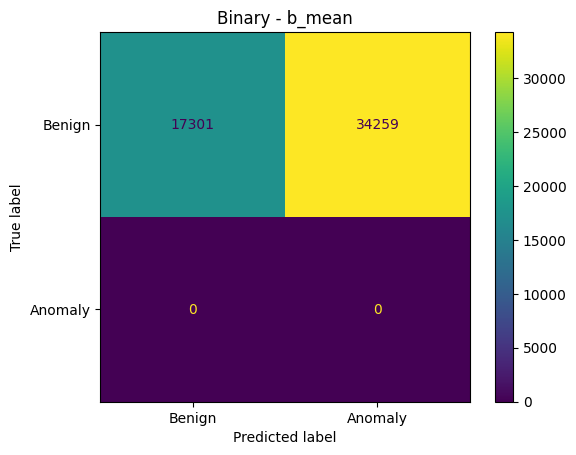

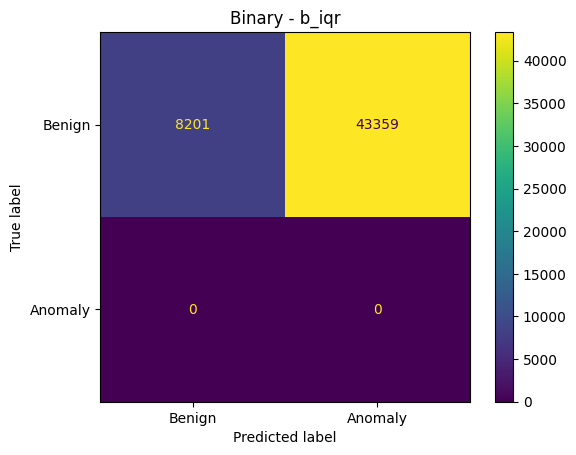

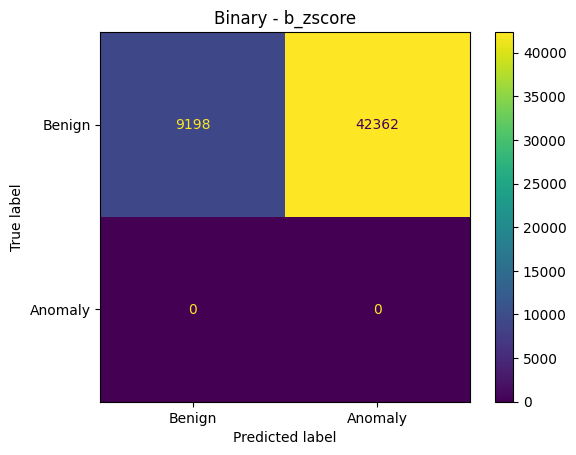

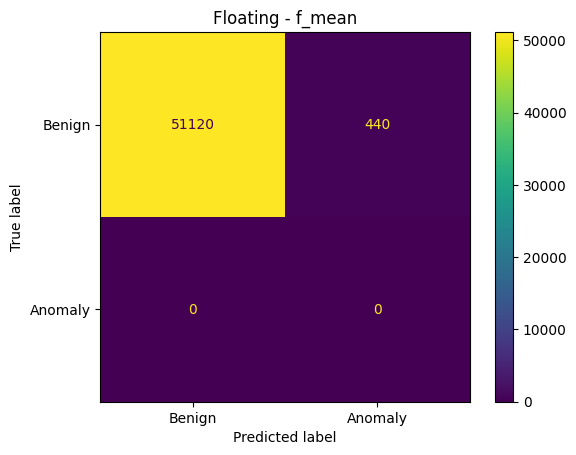

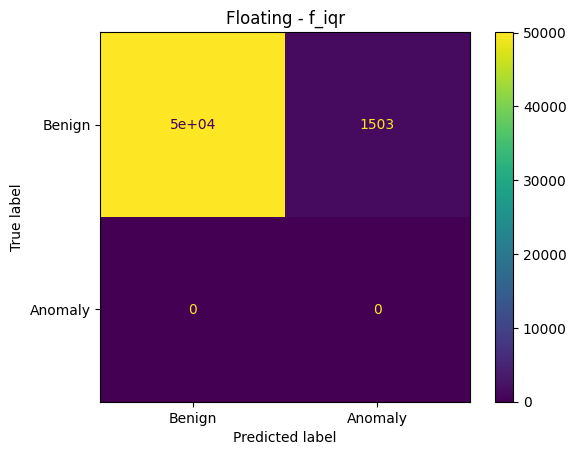

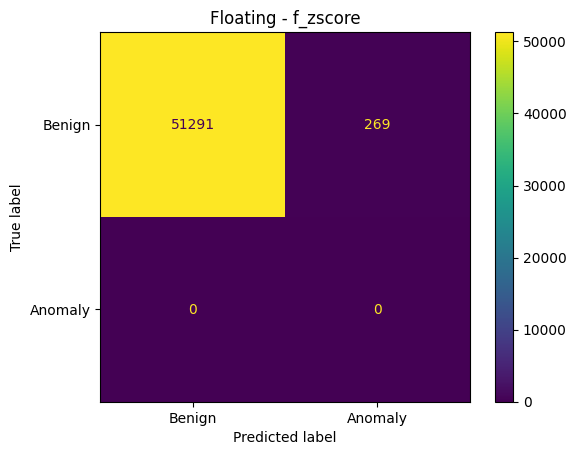

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [25]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.0
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.0
F2-Floating-f_zscore: 0.0


### FPR Score

In [26]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.6644491854150504
FPR-Binary-b_iqr: 0.8409425911559348
FPR-Binary-b_zscore: 0.8216058960434446
FPR-Floating-f_mean: 0.008533747090768037
FPR-Floating-f_iqr: 0.029150504266873545
FPR-Floating-f_zscore: 0.00521722265321955


In [27]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.33555081458494956
Accuracy-Binary-b_iqr: 0.15905740884406516
Accuracy-Binary-b_zscore: 0.17839410395655547
Accuracy-Floating-f_mean: 0.991466252909232
Accuracy-Floating-f_iqr: 0.9708494957331264
Accuracy-Floating-f_zscore: 0.9947827773467804


In [28]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.0,0.0,0.664449,0.335551
b_iqr,0.0,0.0,0.840943,0.159057
b_zscore,0.0,0.0,0.821606,0.178394
f_mean,0.0,0.0,0.008534,0.991466
f_iqr,0.0,0.0,0.029151,0.970849
f_zscore,0.0,0.0,0.005217,0.994783


In [29]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [30]:
# %pip install openpyxl